<a href="https://colab.research.google.com/github/EmmaMills1002/DS3001labs/blob/main/WebScrapingLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cla#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [56]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [57]:
listings[0].find(class_='title').get_text() # Get the title of the first listing

'Rocky boots NEW'

In [58]:
listings[0].find(class_='price').get_text() # Get the title of the first listing

'$50'

In [59]:
listings[0].find(href=True)['href'] # Get the link of the first listing

'https://charlottesville.craigslist.org/clo/d/greenwood-rocky-boots-new/7789805717.html'

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [60]:
import re # Regular expressions

items = ['shirt','skirt','raincoat','briefcase','purse','bag','coats','boots','sandals','uniforms','pants','jeans','costume','shoes','jacket','coat','belt','jewelry','dress','t shirts','t shirt','hat']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get item type from the title string:
    words = title.split()
    hits = [word for word in words if word in items] # Find items in the title
    if len(hits) == 0:
        item = 'missing'
    else:
        item = hits[0]

    data.append({'title':title,'price':price,'link':link,'item':item})

## 2. Get your search results of interest and extract data from them, using code similar to what's above.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [61]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head(5)

(156, 4)


,title,price,link,item
0,rocky boots new,50,https://charlottesville.craigslist.org/clo/d/g...,boots
1,"leather coat,winter coats",1,https://charlottesville.craigslist.org/clo/d/g...,coats
2,"> t-shirt - ""spirit of america"" : never worn, ...",0,https://charlottesville.craigslist.org/clo/d/c...,missing
3,"> hemp t-shirts - never worn, 100% cotton, exc...",0,https://charlottesville.craigslist.org/clo/d/c...,missing
4,"> vintage womens' winter coats - (2), exc cond <",0,https://charlottesville.craigslist.org/clo/d/c...,coats


With the data in and wrangled, we can now do EDA:

count     156.000000
mean       64.333333
std       134.373112
min         0.000000
25%        14.250000
50%        25.000000
75%        60.000000
max      1250.000000
Name: price, dtype: float64


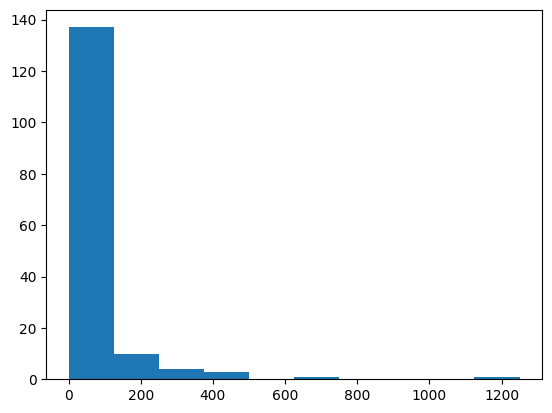

In [62]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [63]:
# Price by item type:
df.loc[:,['price','item']].groupby('item').describe()

price                                                           
         count        mean         std   min    25%   50%     75%     max
item                                                                     
bag        2.0   72.500000   74.246212  20.0  46.25  72.5   98.75   125.0
belt       2.0    7.500000    3.535534   5.0   6.25   7.5    8.75    10.0
boots     11.0   65.909091   40.986472  12.0  45.00  60.0   87.50   150.0
coat       6.0  176.666667  263.014575  20.0  26.25  77.5  151.25   700.0
coats      2.0    0.500000    0.707107   0.0   0.25   0.5    0.75     1.0
costume    3.0   16.000000    8.544004   8.0  11.50  15.0   20.00    25.0
dress      7.0  244.571429  451.342020   0.0  13.50  45.0  195.00  1250.0
hat        2.0   17.500000    3.535534  15.0  16.25  17.5   18.75    20.0
jacket    12.0   71.583333  116.068521   0.0  23.75  35.0   60.00   425.0
jeans     11.0   51.363636   45.996245   0.0   8.00  60.0   80.00   140.0
missing   71.0   55.028169   89.986026   0.0  15.00  25.0   50.00   450.0
pants      6.0   20.000000    7.071068  10.0  16.25  20.0   23.75    30.0
purse      1.0   50.000000         NaN  50.0  50.00  50.0   50.00    50.0
sandals    2.0   17.000000   16.970563   5.0  11.00  17.0   23.00    29.0
shirt      1.0   17.000000         NaN  17.0  17.00  17.0   17.00    17.0
shoes     14.0   50.214286   89.432552   0.0  10.00  22.5   52.25   350.0
skirt      2.0    8.000000    0.000000   8.0   8.00   8.0    8.00     8.0
uniforms   1.0   24.000000         NaN  24.0  24.00  24.0   24.00    24.0

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


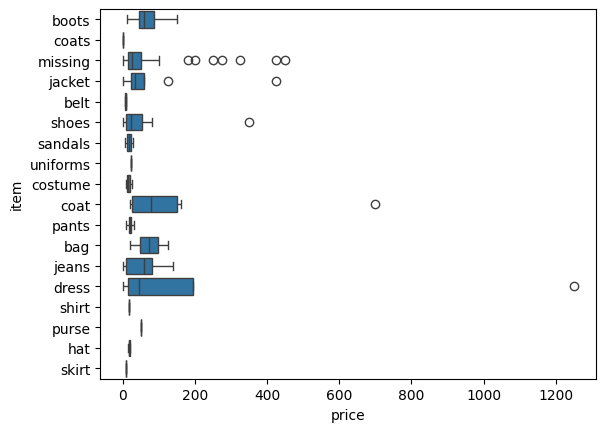

In [64]:
ax = sns.boxplot(data=df, x='price', y='item')

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


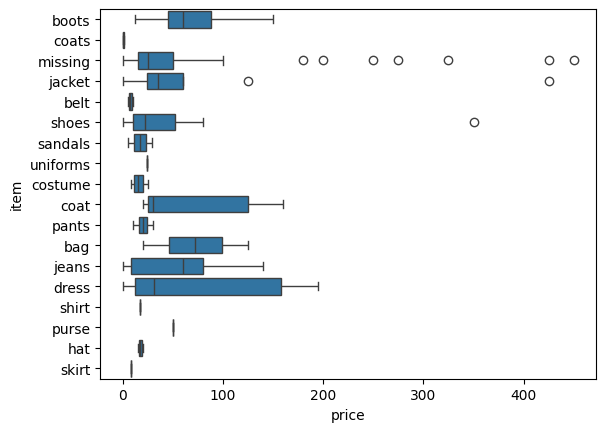

In [65]:
# drop dress and coat outliers so boxplot is easier to read
# Filter out rows where 'price' is 1250
cleaned_data = df[df['price'] != 1250]
cleaned_data = cleaned_data[cleaned_data['price'] != 700]
bx = sns.boxplot(data=cleaned_data, x='price', y='item')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


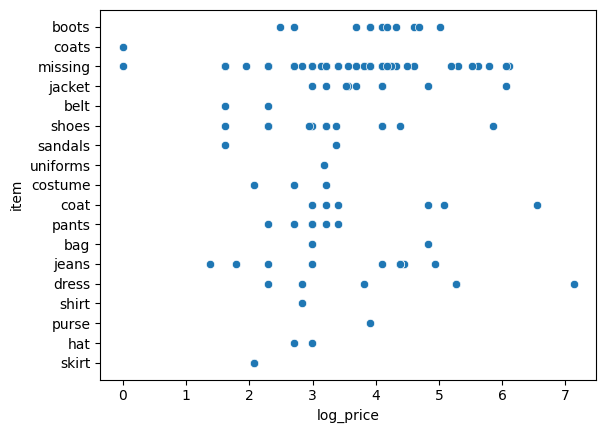

In [66]:
df['log_price'] = np.log(df['price'])

vx = sns.scatterplot(data=df, x='log_price', y='item')


The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [67]:
import time # Time delays
import random # Random numbers

links = df['link']
data2 = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        manufacturer = bsObj.find(class_='attr sale_manufacturer').find(class_ = 'valu').get_text()
        manufacturer = manufacturer.replace('\n','')
    except:
        manufacturer = 'missing'

    record = {'condition':condition,
              'manufacturer':manufacturer,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [68]:
import pandas as pd
new_df2 = pd.DataFrame.from_dict(data2)
print(new_df2.head())

df3 = pd.concat([df,new_df2],axis=1) # combine data frames

df3.to_csv('craiglist_cville_clothes_long.csv')

Empty DataFrame
Columns: []
Index: []


## 4. From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

In [69]:
df3.head()

,title,price,link,item,log_price
0,rocky boots new,50,https://charlottesville.craigslist.org/clo/d/g...,boots,3.912023
1,"leather coat,winter coats",1,https://charlottesville.craigslist.org/clo/d/g...,coats,0.000000
2,"> t-shirt - ""spirit of america"" : never worn, ...",0,https://charlottesville.craigslist.org/clo/d/c...,missing,-inf
3,"> hemp t-shirts - never worn, 100% cotton, exc...",0,https://charlottesville.craigslist.org/clo/d/c...,missing,-inf
4,"> vintage womens' winter coats - (2), exc cond <",0,https://charlottesville.craigslist.org/clo/d/c...,coats,-inf
